In [1]:

import sys
sys.path.append('..')

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

import pandas as pd
import numpy as np
import torch

In [2]:
dataset = "mimic"
model_variant = "shared"
pruning = "movement"

n_concepts = 4
n_atomics = 4
use_summaries_for_atomics = True
encode_time_dim = True # SharedFeature
device = "cpu"
random_state = 1

save_load_path = "/workdir/optimal-summaries-public/_models_train_prune"

In [3]:
set_seed(random_state)
print(len(MIMIC_long_var_names))
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_state)
model = models_3d.CBM(n_concepts=n_concepts, encode_time_dim=encode_time_dim, use_indicators=True, use_summaries=True, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=num_classes, device=device)

# load finetuned mimic
model_path = "/workdir/optimal-summaries-public/_models_train_prune/movement/shared/mimic/finetuned/shared_num_concepts_4_use_indicators_True_encode_time_dim_True_use_summaries_True_seed_1.pt"

model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights, save_model_path=model_path, max_epochs=10000, save_every_n_epochs=10, patience=10, sparse_fit=False)

print("Train")
evaluate_classification(model, train_loader)
print("Val")
evaluate_classification(model, val_loader)
print("Test")
evaluate_classification(model, test_loader)


27


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models_train_prune/movement/shared/mimic/finetuned/shared_num_concepts_4_use_indicators_True_encode_time_dim_True_use_summaries_True_seed_1.pt
Train
AUC macro 0.925
ACC macro 0.851
 F1 macro 0.858
Val
AUC macro 0.910
ACC macro 0.835
 F1 macro 0.843
Test
AUC macro 0.913
ACC macro 0.839
 F1 macro 0.847


(0.9126371145248413, 0.839368462562561, 0.8469087481498718)

In [15]:
print(changing_dim, static_dim, seq_len)
summaries = 12

seq_len + seq_len + summaries + static_dim

27 8 6


32

In [4]:
mask = model.bottleneck.weight_mask.detach()
print(mask.shape)
mask

torch.Size([4, 32])


tensor([[0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
         1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.]])

In [5]:
masked_weights = model.bottleneck.weight.detach() * model.bottleneck.weight_mask.detach()


In [6]:
indices = torch.nonzero(mask)
indices.T

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3],
        [ 2,  3,  6, 12, 15, 16, 17, 27, 30, 31,  1,  7,  8, 16, 17, 20, 21, 23,
         24, 26,  0,  4, 12, 16, 17, 26, 29, 30,  1,  3,  8, 12, 14, 16, 17, 18,
         21, 23, 25, 29]])

In [7]:
selected_indices_per_concept = defaultdict(list)
for concept, feat in indices:
    selected_indices_per_concept[concept.item()].append(feat.item())
selected_indices_per_concept

defaultdict(list,
            {0: [2, 3, 6, 12, 15, 16, 17, 27, 30, 31],
             1: [1, 7, 8, 16, 17, 20, 21, 23, 24, 26],
             2: [0, 4, 12, 16, 17, 26, 29, 30],
             3: [1, 3, 8, 12, 14, 16, 17, 18, 21, 23, 25, 29]})

In [8]:
selected_weights_per_concept = defaultdict(list)
for i in range(len(selected_indices_per_concept)):
    print(selected_indices_per_concept[i])
    selected_weights = (model.bottleneck.weight * model.bottleneck.weight_mask)[i, selected_indices_per_concept[i]].tolist()
    print(selected_weights)
    selected_weights_per_concept[i] = selected_weights
    

[2, 3, 6, 12, 15, 16, 17, 27, 30, 31]
[0.106574147939682, 0.11601254343986511, -7.340487354667857e-05, 0.22314520180225372, 0.07920733839273453, 0.0005119031411595643, 0.001579640549607575, 7.550319423899055e-05, 0.00038989842869341373, -0.30867815017700195]
[1, 7, 8, 16, 17, 20, 21, 23, 24, 26]
[0.0010366968344897032, -4.791338506038301e-05, 0.32469043135643005, -0.15517014265060425, -0.03881241753697395, -0.0025921703781932592, -0.12980780005455017, 0.0009230053401552141, 0.22305834293365479, 0.007698739413172007]
[0, 4, 12, 16, 17, 26, 29, 30]
[0.11908650398254395, 0.2435966581106186, -9.3805581855122e-05, -0.1977376937866211, -0.046955134719610214, -0.00337390904314816, 0.015888415277004242, 1.7419867515563965]
[1, 3, 8, 12, 14, 16, 17, 18, 21, 23, 25, 29]
[-0.0017729002283886075, -0.0010015645530074835, 0.003751084441319108, 7.037394243525341e-05, 0.05429825559258461, 0.0013711093924939632, -0.3226780593395233, -0.0886048749089241, 0.46688225865364075, 0.2528541386127472, 0.273628

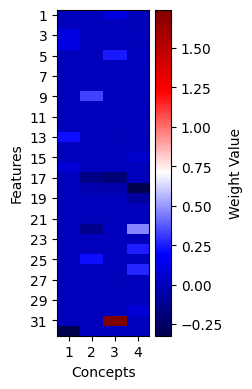

In [9]:
plt.figure(figsize=(2.5, 4))
plt.imshow(masked_weights.T, cmap='seismic', aspect='auto')
plt.colorbar(label='Weight Value')
# plt.title('Heatmap Masked Weights')
plt.ylabel('Features')
plt.xlabel('Concepts')
plt.yticks(range(masked_weights.shape[1])[::2], range(1, masked_weights.shape[1]+1)[::2])
plt.xticks(range(masked_weights.shape[0]), range(1, masked_weights.shape[0]+1))
plt.grid(visible=False)
plt.tight_layout()
plt.savefig("fig/Heatmap Masked Weights.pdf", format="pdf")
plt.show()


In [10]:
concept = 3
selected_feature_names = [MIMIC_long_var_names[i] for i in selected_indices_per_concept[concept]]
idx_to_cnt = [val +1 for val in selected_indices_per_concept[concept]]
df = pd.DataFrame((selected_feature_names, selected_weights_per_concept[concept]), index=["Feature Name", "Weight"], columns=idx_to_cnt).T
df.index.name = "Feature ID"

with open('tex/Concept Features and Weights.tex', 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = df.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)


df

IndexError: list index out of range

In [ ]:
model.lower_thresholds


Parameter containing:
tensor([ 3.6360e-01,  1.7645e-01, -5.2408e-01,  2.8026e-01, -2.3846e-01,
         2.7522e-01,  5.5355e-05, -2.1099e-02, -9.7914e-03, -3.1602e-01,
         1.0260e+00,  3.7318e-01, -1.9746e-01, -6.5019e-01, -1.9798e-01,
        -9.0548e-01,  7.1183e-01, -3.6374e-02, -6.5629e-01, -1.2929e+00,
        -1.7522e-01,  2.0644e-01,  1.4215e+00,  4.2234e-01, -9.1476e-01,
        -1.3901e-01,  1.3505e-01], dtype=torch.float64, requires_grad=True)

In [ ]:
model.upper_thresholds


Parameter containing:
tensor([-6.4801e-01, -5.4514e-02, -4.9605e-01, -4.0337e-01,  3.9178e-01,
         9.6692e-01, -1.7123e-03, -4.1808e-03, -5.0849e-02,  1.4475e-01,
        -5.6309e-01, -2.4207e-01,  1.2397e-01, -7.0674e-01,  1.4134e-01,
        -1.0279e+00, -1.1547e+00,  7.8238e-06,  5.2109e-01, -1.1917e-01,
        -1.5099e-01, -9.5201e-02, -6.5678e-01, -1.1912e+00, -1.0349e+00,
        -2.4817e-01,  2.4595e-01], dtype=torch.float64, requires_grad=True)

In [ ]:
cnt_summaries = 9
cnt_feat = len(MIMIC_long_var_names)

cutoff_percentage = model.cutoff_percentage.reshape(cnt_summaries, cnt_feat) #[0]

In [ ]:
content = []
for sum in cutoff_percentage:
    content.append(sum.tolist())
content.append(model.lower_thresholds.tolist())
content.append(model.upper_thresholds.tolist())

threshhold = ["Lower Thresholds", "Upper Thresholds"]
in_percent = ["Mean Time Series", "Variance Time Series", "Indicator Ever Measured", "Mean Indicators", "Variance Indicators", "Number of Switches", "Slope of a L2 line", "Proportion Below Threshold", "Proportion Above Threshold"]
df = pd.DataFrame(content, index=in_percent + threshhold, columns=MIMIC_long_var_names).T
df

float_format = "{:.2%}"
for col in in_percent:
    df[col] = df[col].map(float_format.format)#.map(lambda x: x.replace("%", "\%")) # escape %

float_format = "{:.3f}"
for col in threshhold:
    df[col] = df[col].map(float_format.format)


with open("tex/summary_parameters_full.tex", 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = df.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)

df_small = df[["Mean Time Series", "Slope of a L2 line", "Proportion Below Threshold", "Lower Thresholds"]]
df_small = df_small.loc[selected_feature_names]
display(df_small)

with open("tex/summary_parameters_small.tex", 'w') as f:
    # tex = per_set.to_latex(convert_css=True)                            # styler
    tex = df_small.to_latex(escape=True)   # df , float_format="{:.2%}".format
    # tex = tex.replace('%', r'\%')
    f.write(tex)


df

,Mean Time Series,Slope of a L2 line,Proportion Below Threshold,Lower Thresholds
Heart Rate,44.07%,0.02%,-0.00%,0.280
Systolic Blood Pressure,33.27%,0.25%,-0.01%,0.275
Magnesium,64.68%,102.05%,-0.18%,1.026
Alanine Aminotransferase,22.26%,-0.03%,-0.03%,-0.650
Hematocrit,0.34%,62.59%,63.45%,-0.198
Partial Pressure of Oxygen,57.44%,0.02%,100.12%,-0.905
Aspartate Aminotransferase,31.53%,79.13%,88.41%,0.712
Bicarbonate,63.70%,65.45%,4.23%,-1.293
Partial Pressure of Carbon Dioxide,5.88%,86.80%,35.36%,1.422
Glucose,0.47%,88.99%,46.83%,0.422


,Mean Time Series,Variance Time Series,Indicator Ever Measured,Mean Indicators,Variance Indicators,Number of Switches,Slope of a L2 line,Proportion Below Threshold,Proportion Above Threshold,Lower Thresholds,Upper Thresholds
Diastolic Blood Pressure,23.20%,97.38%,-0.18%,-0.04%,28.18%,35.11%,55.14%,-0.00%,0.14%,0.364,-0.648
Fraction Inspired Oxygen,4.57%,87.36%,-0.00%,0.00%,4.89%,-0.00%,90.16%,-0.00%,0.00%,0.176,-0.055
Glasgow Coma Scale Total,35.33%,93.02%,0.00%,-0.20%,5.18%,-0.02%,0.26%,2.04%,23.83%,-0.524,-0.496
Heart Rate,44.07%,63.71%,0.00%,-0.00%,-0.01%,1.20%,0.02%,-0.00%,-0.01%,0.280,-0.403
Pulmonary Artery Pressure Mean,43.66%,63.76%,-0.01%,0.18%,-0.03%,0.19%,-0.07%,-0.03%,-0.02%,-0.238,0.392
Systolic Blood Pressure,33.27%,43.76%,-0.03%,50.54%,26.07%,-0.00%,0.25%,-0.01%,76.32%,0.275,0.967
Respiratory Rate,0.00%,62.77%,-0.00%,0.00%,0.44%,-0.00%,0.00%,-0.00%,0.00%,0.000,-0.002
Oxygen Saturation,0.00%,56.93%,0.00%,-0.00%,0.74%,0.00%,17.68%,0.15%,0.23%,-0.021,-0.004
Temperature,67.33%,67.57%,-0.00%,-0.00%,22.42%,4.49%,-0.00%,14.43%,2.24%,-0.010,-0.051
Blood Urea Nitrogen,48.89%,61.82%,-0.08%,-0.00%,1.88%,-0.07%,66.58%,7.37%,0.17%,-0.316,0.145
